<a href="https://colab.research.google.com/github/PaoloBarba/NN_Homework_1/blob/main/NNDS_2023_Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for Data Science Applications
## Homework 1: Saliency maps for interpretability

**Name**: *Paolo*

**Matricola**: *1885324*

> ✍ Upload the completed notebook **before 10/11/2023 at 23:59** on the Google Classroom page.

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# To ensure reproducible results (as much as possible)
tf.keras.utils.set_random_seed(1234)

### Overview

Neural networks are powerful tools, but they are **black-boxes**, meaning that it is difficult to provide human-understandable explanations on what they are doing. The field of **explanaibility** is concerned with finding algorithms for achieving this. In this homework, you will be guided in implementing some basic explanaibility algorithms (**saliency maps**), which is an instructive way of playing with the TensorFlow autodiff framework.

### Instructions

1. The homework is divided into four mandatory exercises (**5 points in total**), and a few optional exercises. Optional exercises are provided if you like the topic and would like to explore more; you are free to ignore them or complete as many as you want. I will not grade them but I might provide feedback for especially nice solutions.
2. Completing the homework successfully will remove 1 exercise from the end-of-term homework.
3. If your grade does not satisfy you, you are also free to complete the full EoT homework to recover it.
3. The grade can be kept for the entire academic year (up to October 2024).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: the homework must be done _fully in TensorFlow_ and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

## Warmup: Data loading

For this homework, you can select any **tabular dataset** that you like, for either classification or regression. A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. The choice of dataset will not influence the mark.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

The dataset originates from Kaggle. It comprises $1599$ records of different kinds of wines considering their chemical properties. Each of the wine has associated a quality score that belongs in $\{1,2,3,4,5\}$. The goal of a predictive model will be to estimate the quality of the wine considering the chemical properties as covariates.




In [3]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.
# Data Loading
import pandas as pd
import numpy as np
from google.colab import files
import os
from zipfile import ZipFile

# Upload the kaggle files
uploaded = files.upload()
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!kaggle datasets download -d uciml/red-wine-quality-cortez-et-al-2009

# Read the dataset from kaggle
with ZipFile('red-wine-quality-cortez-et-al-2009.zip', 'r') as zipObj:
   zipObj.extractall()
   wine = pd.read_csv("winequality-red.csv")

Saving kaggle.json to kaggle.json
  0% 0.00/25.6k [00:00<?, ?B/s]
100% 25.6k/25.6k [00:00<00:00, 43.3MB/s]


In [4]:
# Separete the covariates and the target variable.
X , y = wine.drop(columns=["quality"]) , wine["quality"]

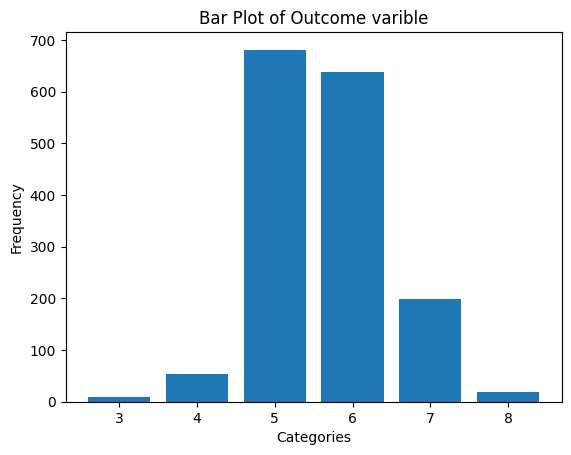

In [5]:
# Let us check the frequencies of the target variable in  order to chooce the best
categ = pd.Series(y)
value_counts = categ.value_counts()

# Create the bar plot
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Bar Plot of Outcome varible')
plt.show()


It is worth noticing that we are dealing with an unbalanced dataset. To deal with that we have to modify the structure of our task, for instance by choosing the appropriate metric to maximize or by downsampling / upsampling our observations. Nevertheless, this is not the actual topic of the homework, given this, we can make some assumptions to simplify the problem by considering just two categories to predict:

- The lower score class :    score $\leq 5$

- The greater score class : score $> 5$

In [6]:
y = np.where(y <= 5 , 0 , 1) # Change the variables into 0 and 1

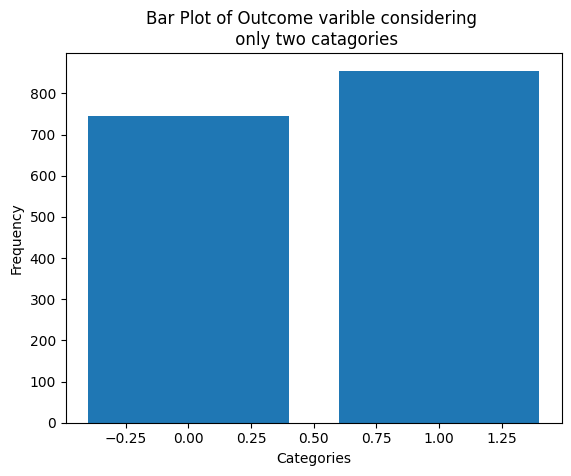

In [7]:
# Let us check the frequencis for each class

categ = pd.Series(y)
value_counts = categ.value_counts()

# Create the bar plot
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Categories')
plt.ylabel('Frequency')
plt.title('Bar Plot of Outcome varible considering \n only two catagories')
plt.show()

Considering only two categories for the target variable, the dataset looks more balanced, ending in an easier implementation of the predictive model.

In [8]:
# Let us split the dataset in train and test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

### Exercise 1: Train a neural network model (1 point)

Define, train, and test a neural network for the provided dataset.

☝ You are free to make any modelling choice (e.g., activation function, normalization layers, etc.), provided the result makes sense.

✅ **Completion requirement**: print on screen the test accuracy of the network. Additional comments and visualizations are also appreciated.

In [9]:
# TODO: define a suitable neural network.

# Define the network architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),   # Layer that normalizes its inputs.
    tf.keras.layers.Dense(256, activation='relu',input_shape=(1,11)), # First layer with relu as the activation function
    tf.keras.layers.Dense(1 , activation = 'sigmoid'),

])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

# Train the modelfit
fitted_model = model.fit(X_train, y_train, epochs=30, batch_size = 32, validation_split = 0.3)


Epoch 1/30
25/25 [==============================] - 7s 14ms/step - loss: 0.6209 - accuracy: 0.6833 - val_loss: 0.9835 - val_accuracy: 0.5744
Epoch 2/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5483 - accuracy: 0.7420 - val_loss: 1.3245 - val_accuracy: 0.5655
Epoch 3/30
25/25 [==============================] - 0s 7ms/step - loss: 0.5213 - accuracy: 0.7522 - val_loss: 1.2641 - val_accuracy: 0.5655
Epoch 4/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5150 - accuracy: 0.7331 - val_loss: 1.1130 - val_accuracy: 0.5714
Epoch 5/30
25/25 [==============================] - 0s 5ms/step - loss: 0.5062 - accuracy: 0.7522 - val_loss: 0.9178 - val_accuracy: 0.5893
Epoch 6/30
25/25 [==============================] - 0s 7ms/step - loss: 0.4968 - accuracy: 0.7561 - val_loss: 0.7614 - val_accuracy: 0.6012
Epoch 7/30
25/25 [==============================] - 0s 5ms/step - loss: 0.4971 - accuracy: 0.7510 - val_loss: 0.6712 - val_accuracy: 0.6161
Epoch 8/30
25/25 [=

Let's analyze the training procedure by plotting:

- Training & validation losses
- Training & validation accuracies


in order to detect if there are some sign of overfitting and underfitting during the training phase.

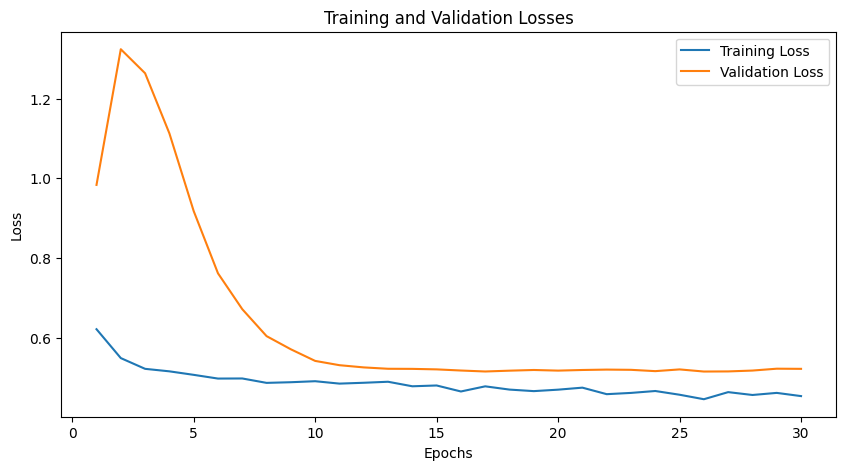

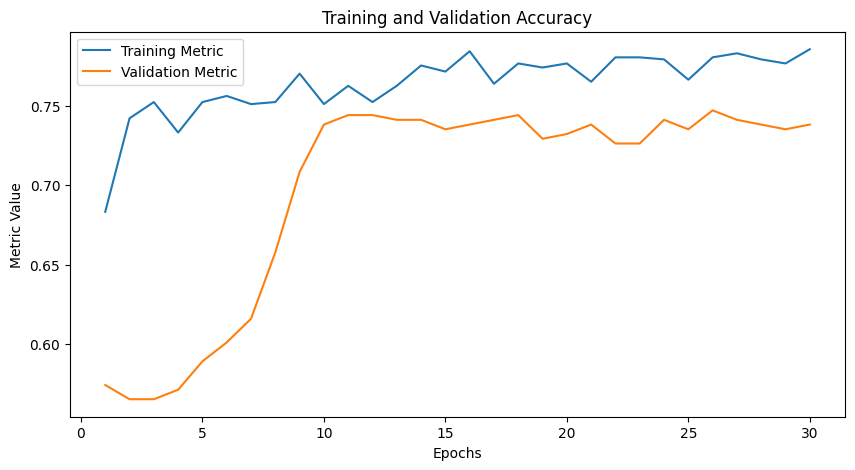

In [11]:
# Compute the training & validation loss
train_loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
# Compute the training & validation accuracy
train_metric = fitted_model.history['accuracy']
val_metric = fitted_model.history['val_accuracy']

# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(train_loss)+1), train_loss, label='Training Loss')
plt.plot(np.arange(1, len(val_loss)+1), val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training metric
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(train_metric)+1), train_metric, label='Training Metric')
plt.plot(np.arange(1, len(val_metric)+1), val_metric, label='Validation Metric')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()


There are no signs of any kind of overfitting and underfitting. We can see a lot of variations on the validation loss. This could be due by the fact that we are dealing with a relative short dataset with $1599$ observations. And the validation metric won't be accurate.

In [ ]:
# TODO: test the neural network and print the result on screen.
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

15/15 [==============================] - 0s 3ms/step - loss: 0.5282 - accuracy: 0.7229


15/15 [==============================] - 0s 4ms/step


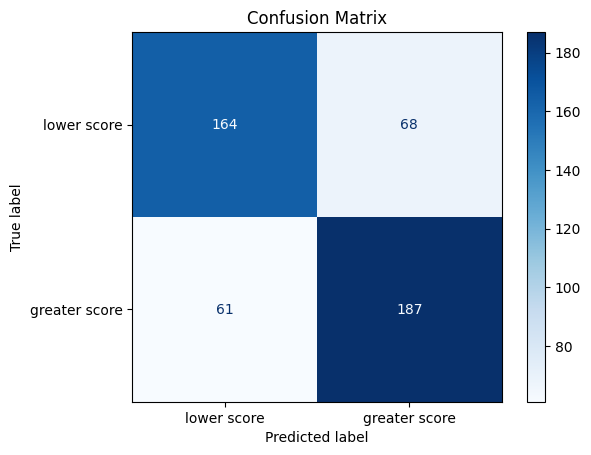

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Perform the predictions over the test dataset
y_pred = model.predict(X_test)
# Decision rule : if y_pred >= .5  predict 1, 0 otherwise
y_pred[y_pred >=.5] = 1
y_pred[y_pred < .5] = 0

# Compute the confusion matric
confusion_mtx = confusion_matrix(y_test, y_pred)

# Define class labels
class_names = ['lower score', 'greater score']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx, display_labels=class_names)
disp.plot(cmap=plt.get_cmap('Blues'), values_format='d')


plt.title('Confusion Matrix')
plt.show()

### Exercise 2: Computing a vanilla saliency map (1 points)

> Before starting, I suggest you read [1] as a warm-up. This is one of the first papers that tried to apply this kind of techniques to modern neural networks.

What do we mean by explainability? Consider the neural network $f(\cdot)$ you just trained, and a prediction $\hat{y} = f(x)$ we want to analyze. **Feature attribution** methods try to assign a weight $w_i$ to each input feature $x_i$, to understand which parts of the input have contributed the most to the explanation.

The simplest feature attribution technique, called **vanilla saliency map**, simply computes the gradient at that point:

$$
  S(x) = \left\lvert \frac{\partial f_c(x)}{\partial x} \right\rvert
$$

where  $c$ is the index corresponding to the predicted class.

✅ **Completion requirement**: Take any point from your test dataset, and compute a saliency map using `tf.GradientTape`. Check the weight to see if you can find anything to "interpret". **Note**: I am not evaluating how nice / good the explanation is, only the code.

In [15]:
# TODO: Take an element from your test set and compute the saliency map
sample = X_test.iloc[0].values  # Take a sample point (class 1)
sample = tf.convert_to_tensor(sample, dtype=tf.float32) # Convert to a tensor
sample = tf.expand_dims(sample, axis=0)                 # Expand the dimension
y_true = y_test[0]              # take the ground truth fot that sample
with tf.GradientTape() as tape:
    tape.watch(sample)          # compute the gradient over the x
    prediction = model(sample)  # compute the predictions

gradients = tape.gradient(prediction, sample) # compute the gradient over the prediction considering the sample
silency_map_1 = np.abs(gradients)       # By taking the absolute values we are compute the vanilla saliency map

In [16]:
sample = X_test.iloc[1].values  # Take a sample point (class 0 )
sample = tf.convert_to_tensor(sample, dtype=tf.float32) # Convert to a tensor
sample = tf.expand_dims(sample, axis=0)                 # Expand the dimension
y_true = y_test[1]              # take the ground truth fot that sample
with tf.GradientTape() as tape:
    tape.watch(sample)          # compute the gradient over the x
    prediction = model(sample)  # compute the predictions

gradients = tape.gradient(prediction, sample)  # compute the gradient over the predction considering the sample
silency_map_0 = np.abs(gradients)        # By taking the absolute values we are compute the vanilla saliency map


Considering true value : 1
The silency map is the following
The most important variable 
 in order to predict is the density 
 with value of the gradient equal to 1.6851271390914917


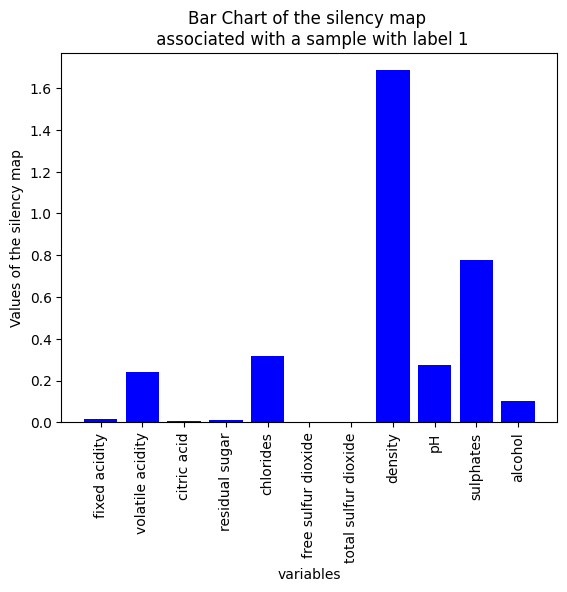

In [19]:
# TODO: Check the saliency map to analyze the result. What can you say about the map?
print(f"Considering true value : {y_test[0]}")
print("The silency map is the following")
plt.bar(X_test.columns, np.reshape(silency_map_1 , -1), color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the silency map \n associated with a sample with label 1')
plt.xticks(rotation=90)
print(f"The most important variable \n in order to predict is the {X.columns[np.argmax(silency_map_1)]} \n with value of the gradient equal to {np.max(silency_map_1)}")

Considering true value : 0
The silency map is the following
The most important variable 
 in order to predict is the density 
 with value of the gradient equal to 0.9260432720184326


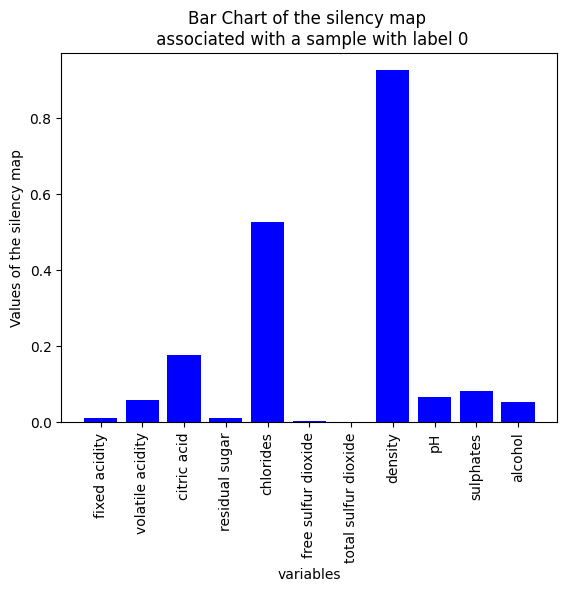

In [20]:
print(f"Considering true value : {y_test[1]}")
print("The silency map is the following")

plt.bar(X_test.columns, np.reshape(silency_map_0 , -1), color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the silency map \n associated with a sample with label 0')
plt.xticks(rotation=90)

print(f"The most important variable \n in order to predict is the {X.columns[np.argmax(silency_map_0)]} \n with value of the gradient equal to {np.max(silency_map_0)}")

### Exercise 3: Advanced saliency maps (1 point)

> For this exercise, you can read [2] for an overview on the limits of vanilla saliency maps and a description of SmoothGrad.

Saliency maps have several issues: most notably, they suffer from noise and they are not stable to small changes in the input or in the model (try running again the training and interpreting the same point). Many methods have been proposed to overcome this.

**[SmoothGrad](https://arxiv.org/abs/1706.03825)**, for example, computes multiple saliency maps from noisy versions of the input:

$$
  \text{SmoothGrad}(x) = \frac{1}{n}\sum_{i=1}^n S(x + \varepsilon_i), \;\; \varepsilon_i \sim \mathcal{N}(0, \sigma^2I)
$$

where $\varepsilon$ is a vector of the same shape as $x$, whose values are sampled from a normal distribution with zero mean and small variance.

🟩 **Completion requirement**: Implement the SmoothGrad procedure for the same point. Has the explanation improved? Bonus points if you can avoid running a for-loop, and by calling the gradient operation a single time.


In [27]:
# TODO: Take an element from your test set and compute SmoothGrad. Check the results and compare with respect to the previous exercise.


n = 100  # set a simulation size

eps = np.random.normal(loc=0.0, scale= 1 , size=(n, 11))  # Generating n samples from a normal distribution
samples = X_test.iloc[0].values + eps                     # Adding the errors terms  by broadcasting
samples = tf.convert_to_tensor(samples, dtype=tf.float32) # Convert to a tensor

with tf.GradientTape() as tape:
    tape.watch(samples)                                   # compute the gradient over the samples
    predictions = model(samples)                          # model predictions

gradients = tape.gradient(predictions, samples)           # compute the actual gradient

smooth_grad = np.mean(np.abs(gradients) , axis = 0)               # compute the mean over all the samples

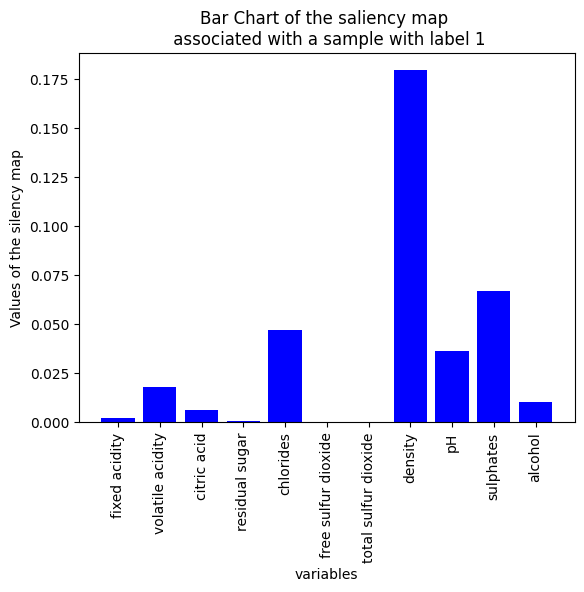

In [28]:
plt.bar(X_test.columns, smooth_grad, color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the saliency map \n associated with a sample with label 1')
plt.xticks(rotation=90)
plt.show()

In [29]:
eps = np.random.normal(loc=0.0, scale= 1 , size=(n, 11))  # Generating n samples from a normal distribution
samples = X_test.iloc[1].values + eps                     # Adding the errors terms  by broadcasting
samples = tf.convert_to_tensor(samples, dtype=tf.float32) # Convert to a tensor

with tf.GradientTape() as tape:
    tape.watch(samples)                                   # compute the gradient over the samples
    predictions = model(samples)                          # model predictions

gradients = tape.gradient(predictions, samples)           # compute the actual gradient

smooth_grad = np.mean(np.abs(gradients) , axis = 0)

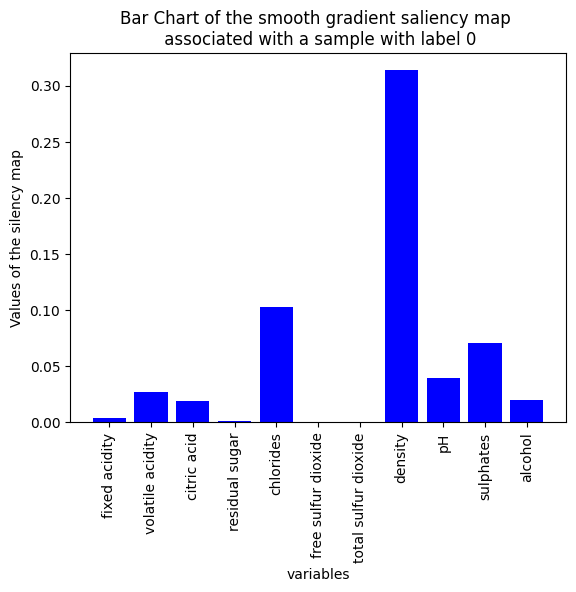

In [30]:
plt.bar(X_test.columns, smooth_grad, color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the smooth gradient saliency map \n associated with a sample with label 0')
plt.xticks(rotation=90)
plt.show()

Comment on the Saliency map by using Smooth Gradient:

The Smooth Gradient Saliency maps computed by the Smooth Gradient look very similar to the vanilla ones for both the samples of the two classes predicted.  
It means that the network actually captures the information inside the data and the predictions were not influenced by the noise.
However for the parameters not that informative (e.g. sulfates) it seems that the importance of that variable in order to predict the quality has dropped while considering the smooth gradient.



### Exercise 4: Global explanations (2 points)

The previous exercises are examples of **local** explanations, where we try to interpret a single prediction of the network. Sometimes we are interested in **global** explanations, that try to find common patterns of behaviour. Suppose we have a dataset $\mathcal{T} = \left\{x_i\right\}$ of examples, we can compute some approximate global measure of influence by averaging their saliency:

$$
\text{GlobalSaliency} = \frac{1}{n} \sum_i S(x_i)
$$

To make this exercise more interesting, we will split it into 3 parts.

**Exercise 4.1**: write a function to compute in parallel the saliency for multiple examples. Note that the resulting matrix $S$ will have shape $(n, d)$, where $n$ is the number of examples and $d$ the size of the input, which is the Jacobian of the network. Try to write the function by avoiding for-loops and multiple tapes, using the [proper tools from TensorFlow](https://www.tensorflow.org/guide/advanced_autodiff).

In [31]:
# TODO: Write the required function, possibly avoding for-loops.

def compute_saliency_map(x,y):
  sample = tf.convert_to_tensor(x, dtype=tf.float32) # Convert the dataset into tensorf flow object
  with tf.GradientTape() as tape:
    tape.watch(sample)
    predictions = tf.reshape(model(sample) , -1)
  gradients = np.abs(tape.gradient(predictions, sample))

  return gradients


**Exercise 4.2**: write a function to compute the global saliency and try to explain the results.

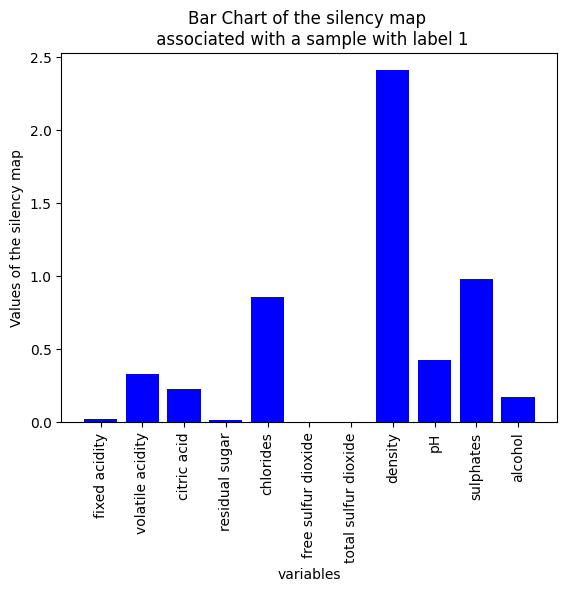

In [33]:
# TODO: Write the required function.


def global_saliency(X,y):
  S = compute_saliency_map(X,y)
  return np.mean(S , axis = 0)



global_saliency_map  = global_saliency(X_test , y_test)


plt.bar(X_test.columns, global_saliency_map, color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the saliency map \n associated with a sample with label 1')
plt.xticks(rotation=90)
plt.show()



Comment on the Global Saliency map:

The values of the Global Saliency map look very similar with respect to the one computed by just one sample, meaning that the sample I have taken before was representative with respect to the dataset.

The most informative feature seems to be the density while the less informative one seems to be both free sulfur dioxide and total sulfur dioxide. An idea would be to remove this two features that apparently are just introducing noise in the predictions.

**Exercise 4.3**: note that a linear model $f(x) = w^\top x + b$ is an example of an *intrinsically* interpretable  model, since the weights $w$ can be checked to analyze the global saliency of each feature (see [3]).

In [ ]:
# TODO: Compare the results you obtained before with a simpler linear model.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model_lr = LogisticRegression()

# Train the model
model_lr.fit(X_train, y_train)


y_pred = model_lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)


coefficients = model_lr.coef_
intercept = model_lr.intercept_

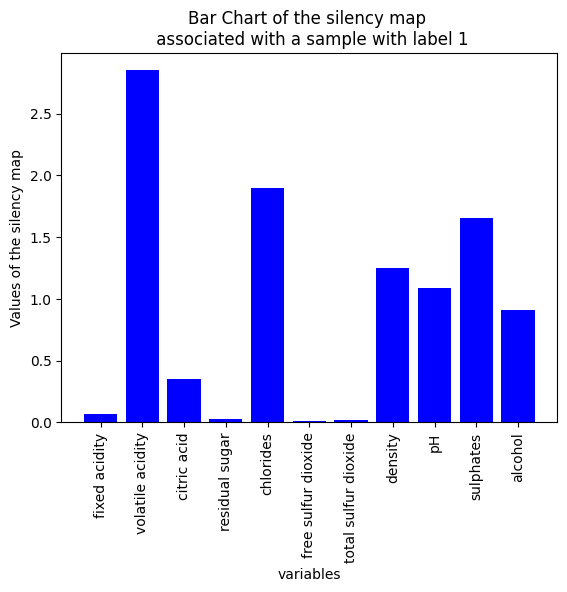

In [ ]:
plt.bar(X_test.columns, np.reshape(np.abs(coefficients),-1) , color='blue')
plt.xlabel('variables')
plt.ylabel('Values of the silency map')
plt.title('Bar Chart of the silency map \n associated with a sample with label 1')
plt.xticks(rotation=90)
plt.show()

### Optional exercises and parting words

> ⚠ Explainability is a complex topic, with multiple issues arising from the over-abundance of techniques, their instability, etc. While an interesting research topic to pursue, never use blindly these techniques in high-stake applications!

These exercises were just a brief and short introduction to the topic of explainability. Below you can find some additional exercises to tackle if you are interested. Remember that these are not part of your grade, but I am happy to provide feedback if they are of interest to you.

1. There are dozens of possible variations on feature attribution methods, which may or may not provide better results (see [4] for a benchmarking and this nice [Distill blog post](https://distill.pub/2020/attribution-baselines/)). **[Integrated Gradients](https://arxiv.org/abs/1703.01365)** are an interesting example, where the saliency is integrated over a path ranging from an empty input to the true input. Try implementing integrated gradients.
2. **Data attribution** methods are a different class of explanation methods, which try to predict what points in the dataset where most influential to a given prediction (e.g., a picture of a cat will be especially influential on similar pictures). One example of such methods is TracIn [5], which stores checkpoints of the model during training and evaluates the correlation of the gradients. Try to implement TracIn or any other metric of data influence.
3. A recent line of research tries to use large language models (e.g., ChatGPT) to explain other models (e.g., see [Language models can explain neurons in language models](https://openai.com/research/language-models-can-explain-neurons-in-language-models)). If you have access to an LLM, you can try it! Take a specific neuron in the model, and collect the activation for multiple examples. Provide these activations to the LLM, and prompt it to provide a human-understandable explanation. What is the result?

### Final checklist

1. Carefully check all code. Insert comments when needed. Search for "TODO" to see if you forgot something.
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Upload the completed notebook **before 10/11/2023 23:59** on the Google Classrom page.

### Bibliography

[1] Simonyan, K., Vedaldi, A. and Zisserman, A., 2013. [Deep inside convolutional networks: Visualising image classification models and saliency maps](https://arxiv.org/abs/1312.6034). arXiv preprint arXiv:1312.6034.

[2] Smilkov, D., Thorat, N., Kim, B., Viégas, F. and Wattenberg, M., 2017. [SmoothGrad: removing noise by adding noise](https://arxiv.org/abs/1706.03825). arXiv preprint arXiv:1706.03825.

[3] Rudin, C., 2019. [Stop explaining black box machine learning models for high stakes decisions and use interpretable models instead](https://www.nature.com/articles/s42256-019-0048-x). Nature Machine Intelligence, 1(5), pp. 206-215.

[4] Nguyen, G., Kim, D. and Nguyen, A., 2021. [The effectiveness of feature attribution methods and its correlation with automatic evaluation scores](https://proceedings.neurips.cc/paper/2021/hash/de043a5e421240eb846da8effe472ff1-Abstract.html). Advances in Neural Information Processing Systems, 34, pp.26422-26436.

[5] Pruthi, G., Liu, F., Kale, S. and Sundararajan, M., 2020. [Estimating training data influence by tracing gradient descent](https://proceedings.neurips.cc/paper/2020/hash/e6385d39ec9394f2f3a354d9d2b88eec-Abstract.html). Advances in Neural Information Processing Systems, 33, pp. 19920-19930.